<a href="https://colab.research.google.com/github/hardscrey/steam-user-clustering/blob/main/portfolio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import zipfile
import os
import shutil
import json
import sqlite3

In [ ]:
src_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'
dst_path = '/content/steam_profiles.zip'

shutil.copy(src_path, dst_path)


'/content/steam_profiles.zip'

In [ ]:
with zipfile.ZipFile('/content/steam_profiles.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/steam_data')

In [ ]:
db_path = '/content/steam_data/users'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())


[('accounts',)]


In [ ]:
cursor.execute("PRAGMA table_info(accounts);")
for col in cursor.fetchall():
    print(col)


(0, 'steamID', 'INTEGER', 0, None, 1)
(1, 'games_used', 'BOOLEAN', 0, None, 0)
(2, 'friends_available', 'BOOLEAN', 0, None, 0)
(3, 'friends', 'JSONB', 0, None, 0)
(4, 'games', 'JSONB', 0, None, 0)


In [ ]:
cursor.execute("SELECT * FROM accounts LIMIT 20;")
rows = cursor.fetchall()



(76561197960265730, 0, 0, '["76561197984632295","76561198010062752","76561198018064800","76561197974593417","76561197969518075","76561198040900440","76561197960265733","76561199229705722","76561197960265744","76561197964217171","76561197972495328"]', '')
(76561197960265731, 0, 0, '["76561197991518342","76561197991390878","76561197987253686","76561197970953718","76561198009923298","76561197968575517","76561197989701891","76561197964279229","76561197991983406","76561197960464481","76561197960402283","76561198886622096","76561197960279927","76561197967643346","76561198010062752","76561197960271495","76561197978236369","76561197960549564","76561197964620212","76561197960265838","76561197982240193","76561197974593417","76561197962783665","76561197971596380","76561197980744144","76561197962205142","76561197968499581","76561197992927490","76561197985244272","76561197963156385","76561197969221324","76561197990502939","76561197996226415","76561199093814217","76561198877374010","7656119804098426

In [ ]:
cursor.execute("SELECT steamID, games_used, friends_available, friends, games\
                FROM accounts\
                WHERE games_used = 1\
                AND games IS NOT NULL\
                AND games != '[]'\
                LIMIT 50000\
                ")
rows = cursor.fetchall()

In [ ]:
processed_data = []

for row in rows:
    steam_id, games_used, friends_available, friends_json, games_json = row

    try:
        friends = json.loads(friends_json) if friends_json else []
        games = json.loads(games_json) if games_json else []
    except Exception:
        continue

    num_friends = len(friends)
    num_games = len(games)

    total_playtime_forever = sum(game.get('playtime_forever', 0) for game in games)
    total_playtime_2weeks = sum(game.get('playtime_2weeks', 0) for game in games)

    avg_playtime = total_playtime_forever / num_games if num_games > 0 else 0
    recommend_rate = (sum(1 for game in games if game.get('is_recommended') == 1) / num_games if num_games > 0 else 0)

    processed_data.append({
        'steamID': steam_id,
        'games_used': games_used,
        'friends_available': friends_available,
        'num_friends': num_friends,
        'num_games': num_games,
        'total_playtime_forever': total_playtime_forever,
        'total_playtime_2weeks': total_playtime_2weeks,
        'avg_playtime_per_game': avg_playtime,
        'recommend_rate': recommend_rate
    })



In [ ]:
df = pd.DataFrame(processed_data)

In [ ]:
df['total_playtime_forever_hr'] = df['total_playtime_forever'] / 60
df['total_playtime_2weeks_hr'] = df['total_playtime_2weeks'] / 60
df['avg_playtime_per_game_hr'] = df['avg_playtime_per_game'] / 60

In [ ]:
df = df.drop(['friends_available', 'total_playtime_forever', 'total_playtime_2weeks', 'avg_playtime_per_game', 'games_used', 'steamID'], axis=1)

In [ ]:
df

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,total_playtime_2weeks_hr,avg_playtime_per_game_hr
0,397,857,0.005834,24575.316667,63.833333,28.675982
1,0,352,0.005682,12821.783333,0.000000,36.425521
2,82,386,0.038860,1091.016667,26.883333,2.826468
3,395,160,0.006250,0.000000,0.000000,0.000000
4,200,221,0.009050,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
49995,0,703,0.004267,8689.350000,18.016667,12.360384
49996,0,214,0.051402,9003.133333,23.833333,42.070717
49997,0,49,0.020408,0.000000,0.000000,0.000000
49998,0,1093,0.026532,19601.283333,37.150000,17.933471


In [ ]:
df.describe()

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,total_playtime_2weeks_hr,avg_playtime_per_game_hr
count,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000
mean,4.778740,606.812020,0.025449,9.891377e+03,38.229543,40.042904
std,35.067653,1139.169369,0.039043,2.301640e+04,180.117915,90.789813
min,0.000000,3.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,171.000000,0.005510,4.123475e+03,0.050000,8.918474
50%,0.000000,339.000000,0.013060,7.814608e+03,17.150000,21.761951
75%,0.000000,629.000000,0.029703,1.264044e+04,47.666667,44.362681
max,1579.000000,32888.000000,1.000000,2.548579e+06,10692.800000,5793.895486


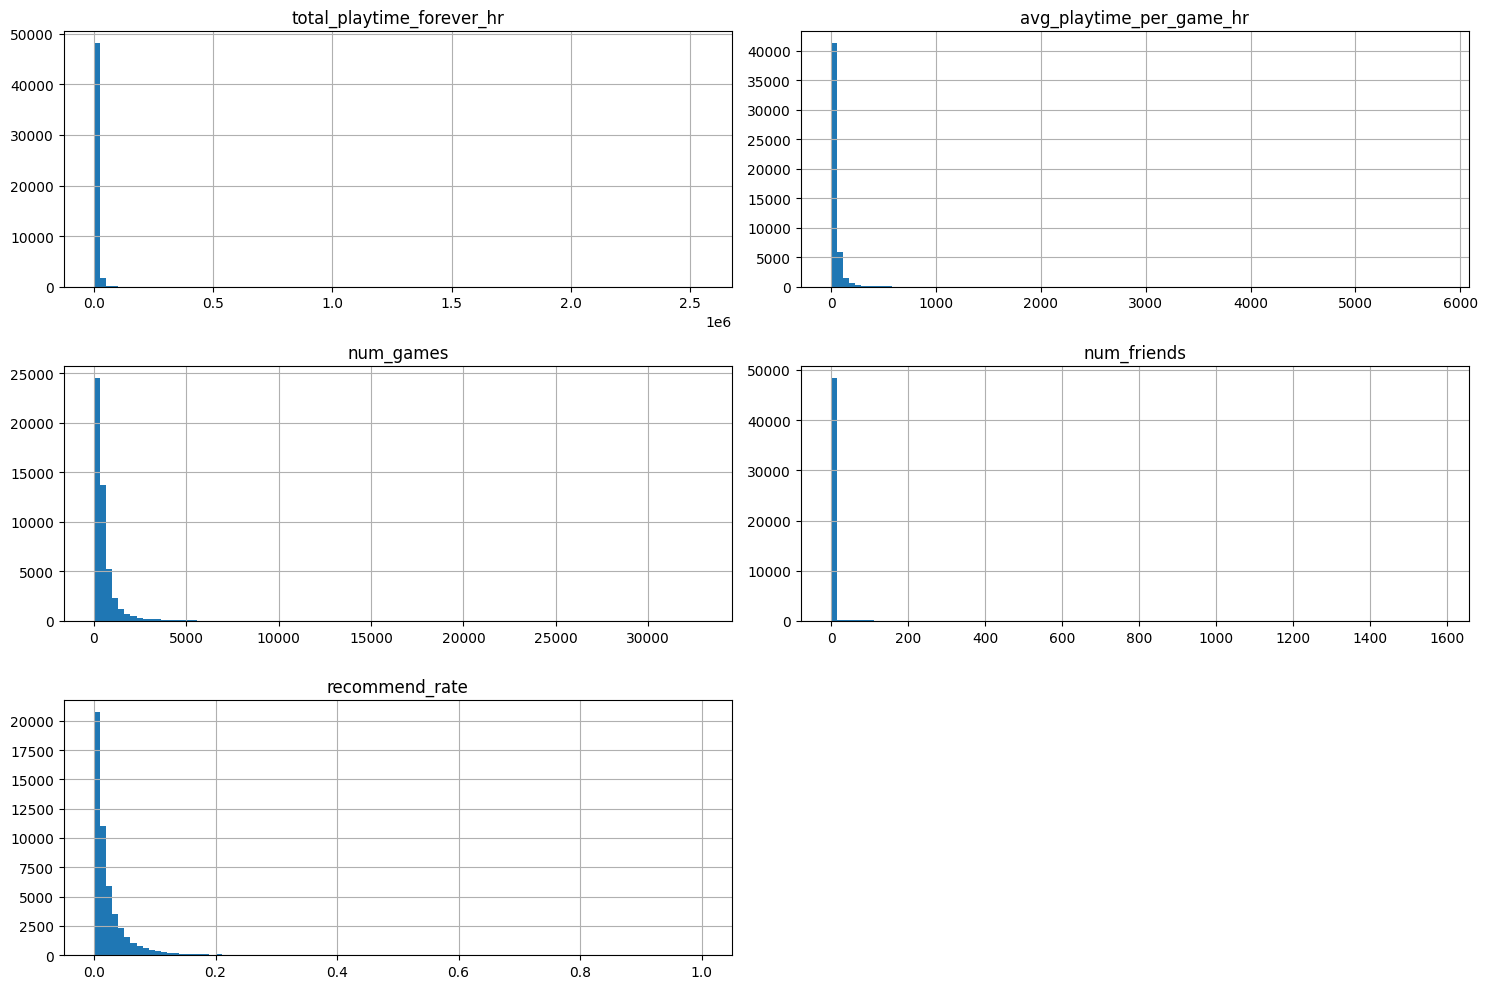

In [ ]:
cols = ['total_playtime_forever_hr', 'avg_playtime_per_game_hr', 'num_games', 'num_friends', 'recommend_rate']
df[cols].hist(bins=100, figsize=(15, 10))
plt.tight_layout()
plt.show()

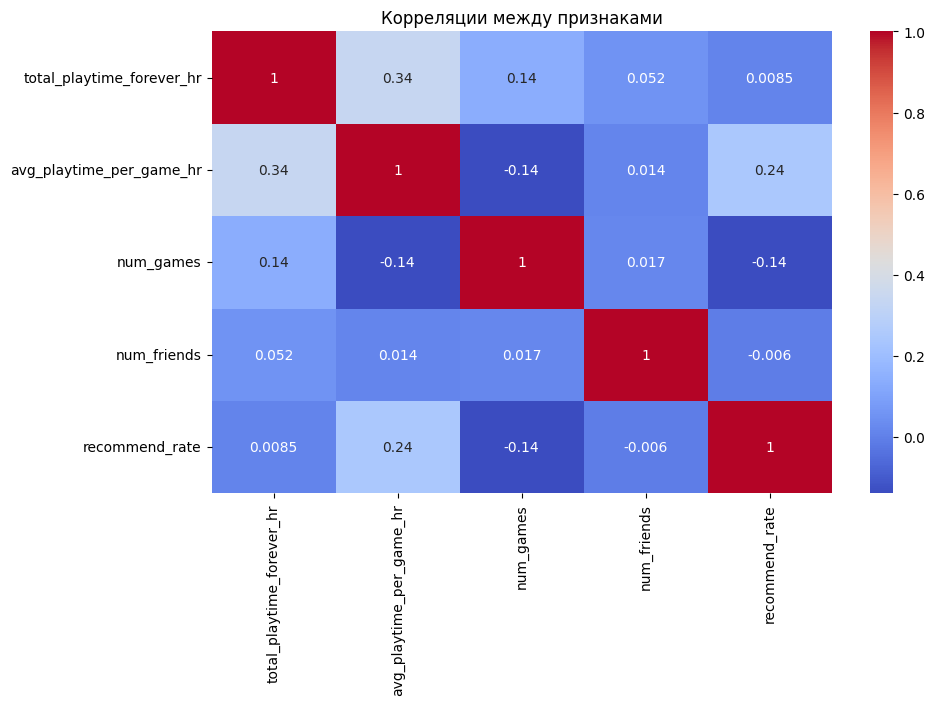

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Корреляции между признаками")
plt.show()

In [ ]:
low = df[['num_games', 'total_playtime_forever_hr', 'total_playtime_2weeks_hr', 'avg_playtime_per_game_hr']].quantile(0.0)
high = df[['num_games', 'total_playtime_forever_hr', 'total_playtime_2weeks_hr', 'avg_playtime_per_game_hr']].quantile(0.98)
mask = (df[['num_games', 'total_playtime_forever_hr', 'total_playtime_2weeks_hr', 'avg_playtime_per_game_hr']] >= low) & (df[['num_games', 'total_playtime_forever_hr', 'total_playtime_2weeks_hr', 'avg_playtime_per_game_hr']] <= high)
df_filtered = df[mask.all(axis=1)]

In [ ]:
df_filtered

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,total_playtime_2weeks_hr,avg_playtime_per_game_hr
0,397,857,0.005834,24575.316667,63.833333,28.675982
1,0,352,0.005682,12821.783333,0.000000,36.425521
2,82,386,0.038860,1091.016667,26.883333,2.826468
3,395,160,0.006250,0.000000,0.000000,0.000000
4,200,221,0.009050,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
49995,0,703,0.004267,8689.350000,18.016667,12.360384
49996,0,214,0.051402,9003.133333,23.833333,42.070717
49997,0,49,0.020408,0.000000,0.000000,0.000000
49998,0,1093,0.026532,19601.283333,37.150000,17.933471


In [ ]:
df_filtered.describe()

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,total_playtime_2weeks_hr,avg_playtime_per_game_hr
count,46747.000000,46747.000000,46747.000000,46747.000000,46747.000000,46747.000000
mean,4.443986,485.353926,0.024668,8376.996608,28.423415,31.705396
std,32.666809,490.262112,0.036205,6177.863203,34.622304,34.246222
min,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,174.000000,0.005629,3916.550000,0.000000,9.060077
50%,0.000000,334.000000,0.013072,7445.283333,15.850000,21.208814
75%,0.000000,602.000000,0.029126,11845.225000,44.316667,41.789737
max,1304.000000,3358.000000,0.750000,31239.633333,181.033333,211.137374


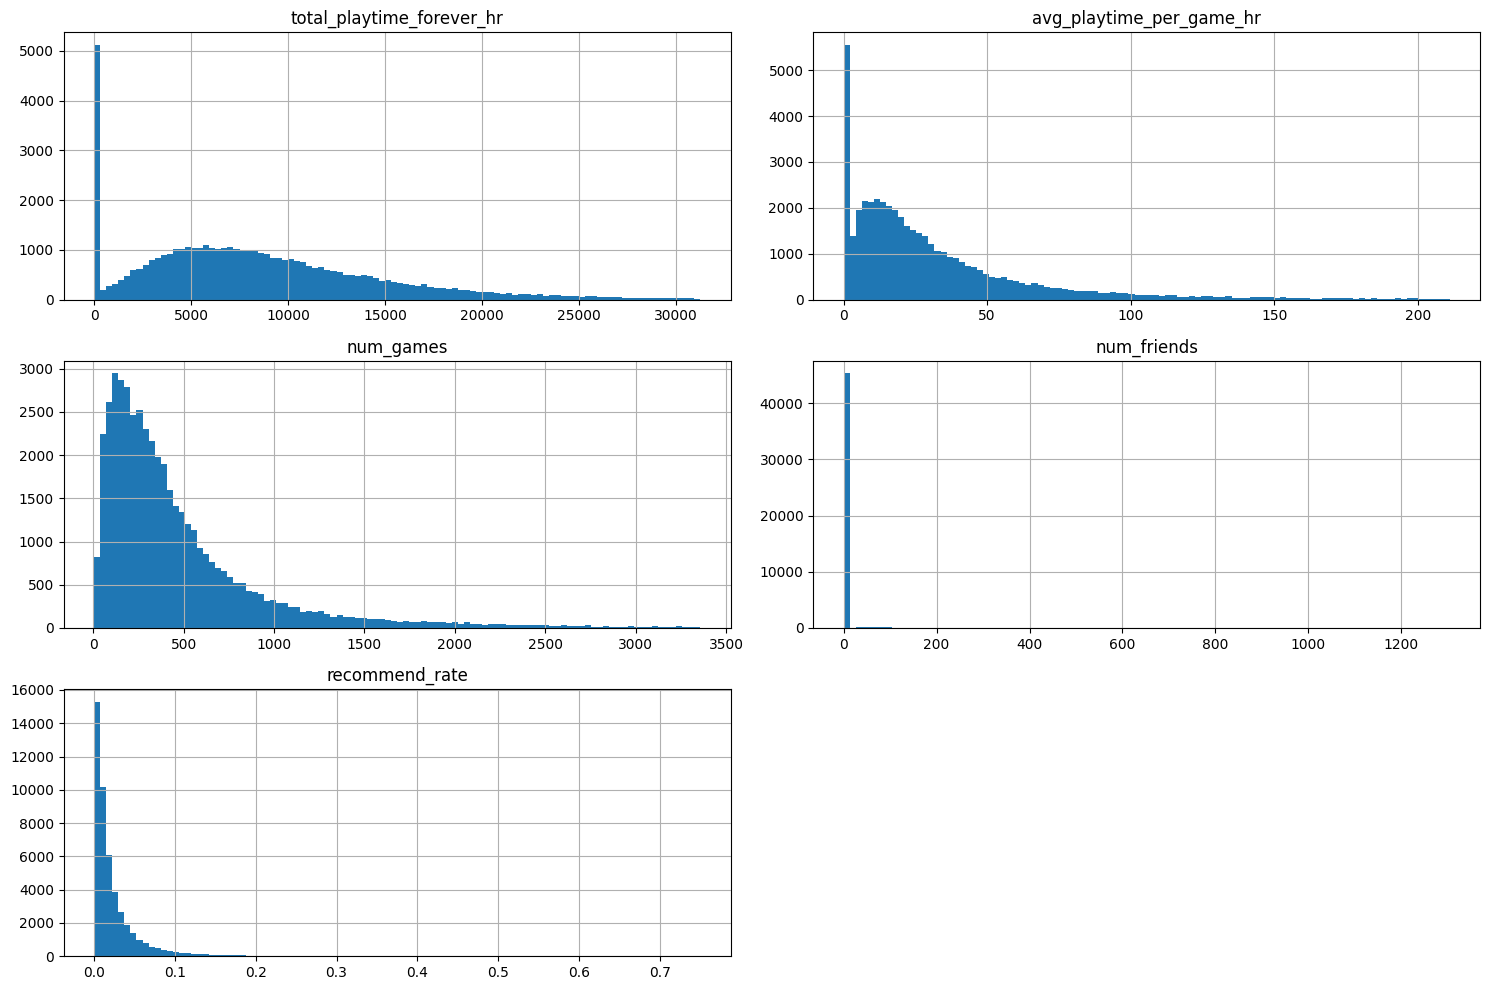

In [ ]:
cols = ['total_playtime_forever_hr', 'avg_playtime_per_game_hr', 'num_games', 'num_friends', 'recommend_rate']
df_filtered[cols].hist(bins=100, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Масштабируем
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)

# Определим оптимальное количество кластеров (по методу локтя)
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

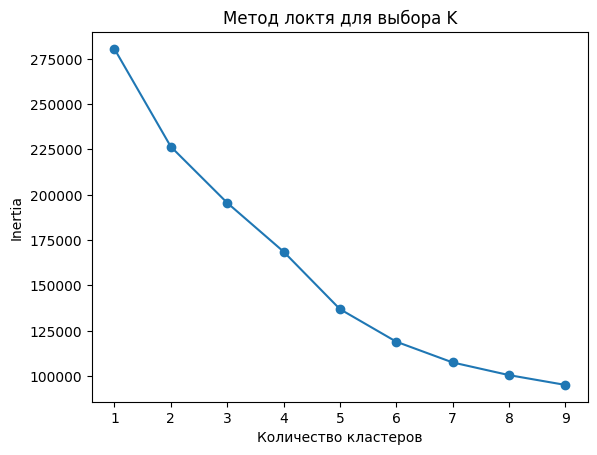

In [ ]:
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel("Количество кластеров")
plt.ylabel("Inertia")
plt.title("Метод локтя для выбора K")
plt.show()

<ipython-input-22-a9f7e3c631ed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust["cluster"] = clusters
<ipython-input-22-a9f7e3c631ed>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust["pca_1"] = components[:, 0]
<ipython-input-22-a9f7e3c631ed>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

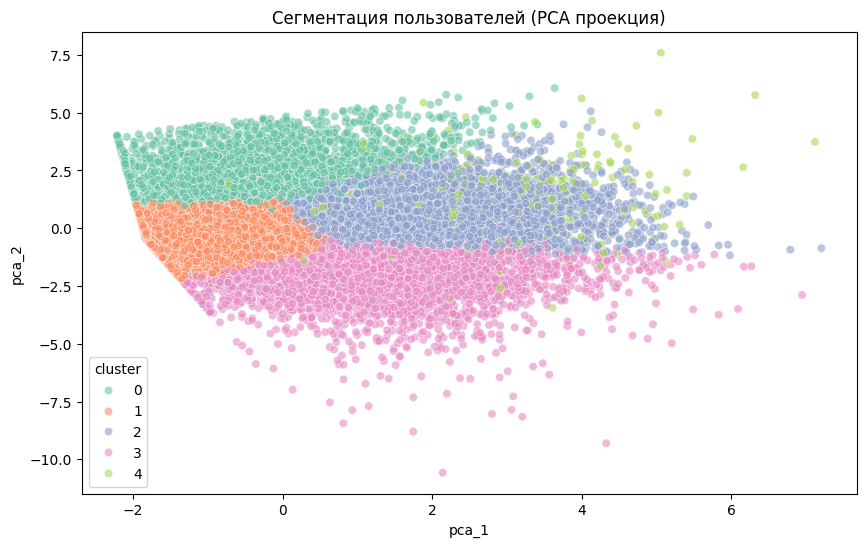

In [ ]:
df_clust = df_filtered
# Кластеризация
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Сохраняем кластеры в датафрейм
df_clust["cluster"] = clusters

# PCA для визуализации
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df_clust["pca_1"] = components[:, 0]
df_clust["pca_2"] = components[:, 1]

# Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clust, x="pca_1", y="pca_2", hue="cluster", palette="Set2", alpha=0.6)
plt.title("Сегментация пользователей (PCA проекция)")
plt.show()


In [ ]:
df_clust['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

<ipython-input-23-23a0cbf239c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust['kmeans_cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(X_scaled, kmeans.labels_)

np.float64(0.32552990952261934)

In [ ]:
df_clusters = df_clust.groupby('kmeans_cluster')[['num_friends', 'num_games', 'recommend_rate','total_playtime_forever_hr', 'avg_playtime_per_game_hr']].mean()


In [ ]:
df_clusters

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,avg_playtime_per_game_hr
kmeans_cluster,,,,,
0,1.183439,1694.907342,0.011839,10084.354910,6.506480
1,0.995384,362.317525,0.018542,5050.757109,18.653273
2,2.198042,485.950678,0.017633,14849.633840,39.258745
3,0.739837,137.166159,0.073051,9441.395006,91.697821
4,245.490164,504.231148,0.023081,11621.081530,37.934983


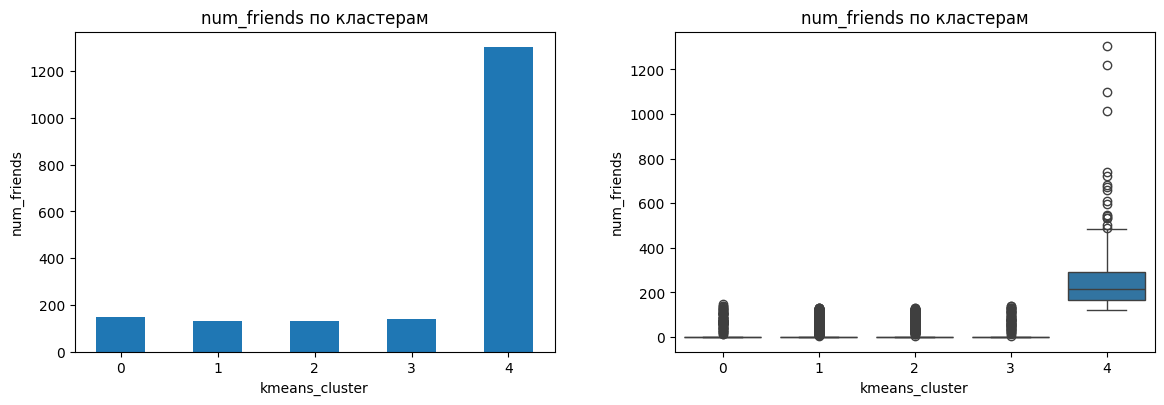

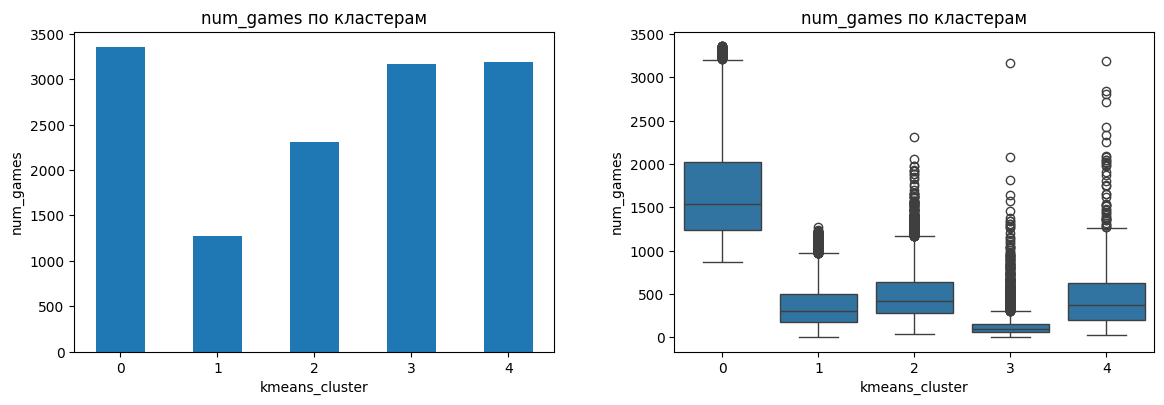

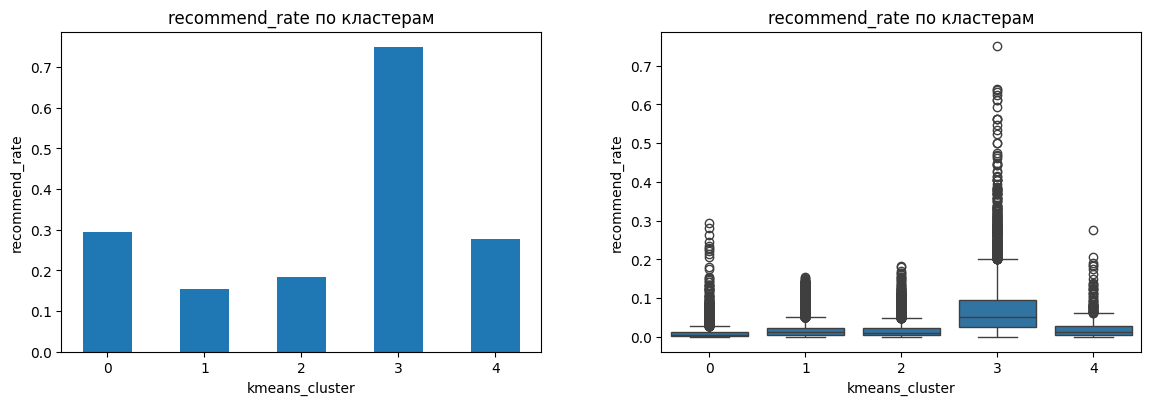

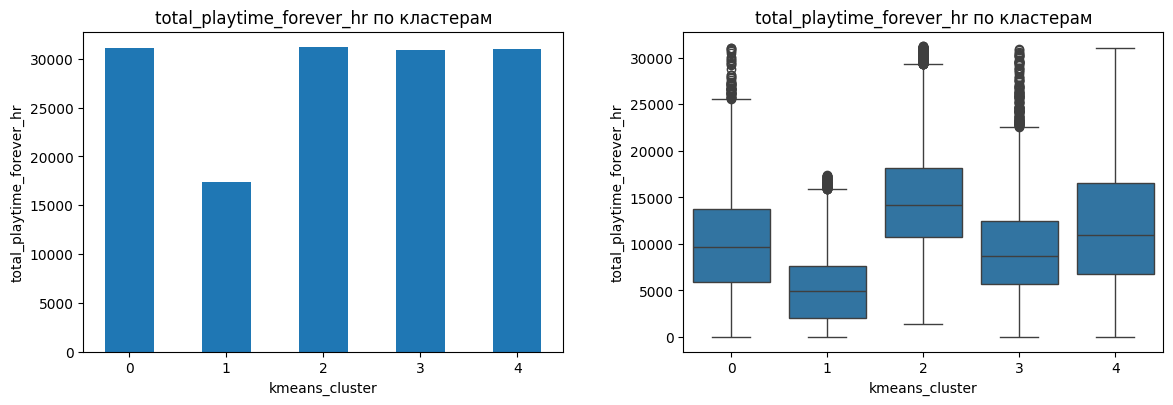

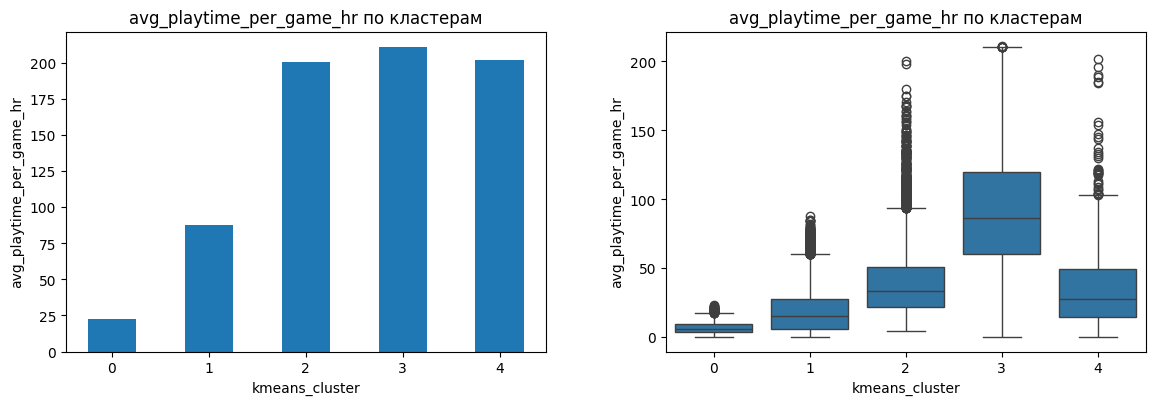

In [ ]:
features = ['num_friends', 'num_games', 'recommend_rate', 'total_playtime_forever_hr', 'avg_playtime_per_game_hr']

for col in features:
    fig = plt.figure(figsize=(6, 4))

    ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax2 = fig.add_axes([1.1, 0.1, 0.8, 0.8])

    ax1.bar(x=df_clust['kmeans_cluster'], height=df_clust[col], width = 0.5)
    sns.boxplot(x=df_clust['kmeans_cluster'], y=df_clust[col], ax=ax2)

    #ax1.set_xlim(0,10000)
    ax1.set_xlabel('kmeans_cluster')
    ax1.set_ylabel(col)
    ax1.set_title(f'{col} по кластерам')
    #ax1.legend()

    ax2.set_xlabel('kmeans_cluster')
    ax2.set_ylabel(col)
    ax2.set_title(f'{col} по кластерам')
    #ax2.legend()
    #ax2.tick_params(axis='x', labelrotation = 75)

    plt.show()

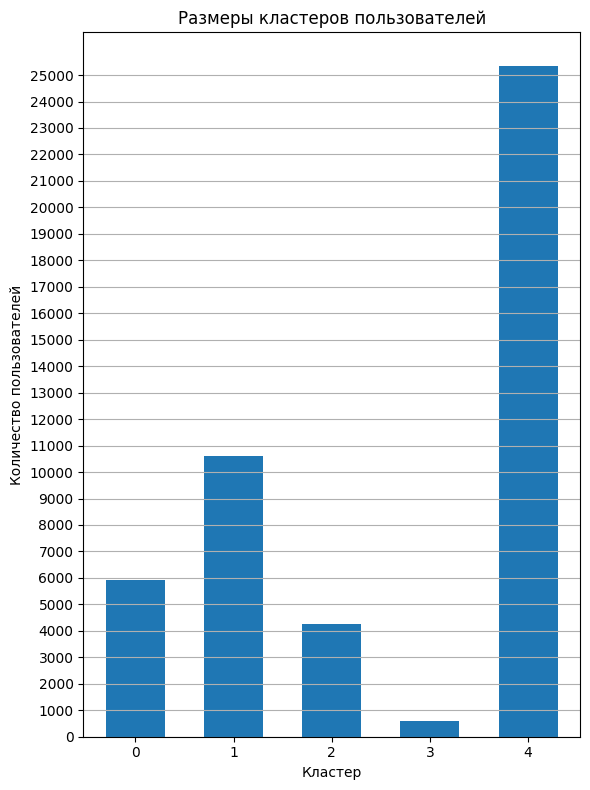

In [ ]:
plt.figure(figsize=(6, 8))
plt.bar(x=df_clust['kmeans_cluster'].unique(), height=df_clust['kmeans_cluster'].value_counts(), width=0.6)
plt.title('Размеры кластеров пользователей')
plt.xlabel('Кластер')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')
plt.tight_layout()
plt.yticks(np.arange(0, 26000, 1000))
plt.show()

# 2